### ELEvo run for the May 2024 superstorm

This script simulates the propagation of the five CMEs that caused the May 2024 superstorm. 
    
To run this script use the helio4.yml environment. 

In [1]:
#change path for ffmpeg for animation production if needed

ffmpeg_path=''

import os
import datetime
from datetime import datetime, timedelta
from sunpy.time import parse_time
import sunpy
import astropy.units as u
from concurrent.futures import ThreadPoolExecutor
from functools import partial
import itertools

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import spiceypy
import pandas as pd
from joblib import Parallel, delayed

import matplotlib.cm as cmap
import matplotlib.font_manager as font_manager
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from scipy.signal import medfilt
from scipy.stats import norm
import numpy as np
import pdb
import pickle
import seaborn as sns
import sys
import heliopy.data.spice as spicedata
import heliopy.spice as spice
import astropy
import importlib    
import time
import numba
from numba import jit
import multiprocessing
import multiprocess as mp
import urllib
import copy
from astropy import constants as const
import astrospice
import shutil

import warnings
warnings.filterwarnings('ignore')

data_path = '/data/'
results_path = 'elevo_output/'

if os.path.isdir(data_path) == False: os.mkdir(data_path)
if os.path.isdir(results_path) == False: os.mkdir(results_path)

/export/home/aswo/eweiler/miniconda3/envs/helio4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PermissionError: [Errno 13] Permission denied: '/elevo_output/'

#### generate DONKI kinematics (using elevo) & arrival times/speeds

In [3]:
def cart2sphere(x,y,z):
    r = np.sqrt(x**2+ y**2 + z**2)           
    theta = np.arctan2(z,np.sqrt(x**2+ y**2))
    phi = np.arctan2(y,x)                    
    return (r, theta, phi)

def plot_stereo_hi_fov(pos, time_num, timeind,ax,sc):    
    
    #plots the STA FOV HI1 HI2
    
    #STB never flipped the camera:    
    if sc=='B': 
        ang1d=-4
        ang2d=-24
        ang3d=-18
        ang4d=-88
        lcolor='blue'
    
    if sc=='A': 
        ang1d=4
        ang2d=24
        ang3d=18
        ang4d=88
        lcolor='red'

        #STA flipped during conjunction
        if mdates.date2num(datetime(2015,11,1))<time_num<mdates.date2num(datetime(2023,8,12)):  
            ang1d=-4
            ang2d=-24
            ang3d=-18
            ang4d=-88



    #calculate endpoints
    
    #sta position
    x0=pos.x[timeind]
    y0=pos.y[timeind]
    z0=0
    
    #sta position 180° rotated    
    x1=-pos.x[timeind]
    y1=-pos.y[timeind]
    z1=0
    
    #rotate by 4 deg for HI1 FOV
    ang=np.deg2rad(ang1d)
    rot=np.array([[np.cos(ang), -np.sin(ang)], [np.sin(ang), np.cos(ang)]])    
    [x2,y2]=np.dot(rot,[x1,y1])
    z2=0    
    #add to sta position
    x2f=x0+x2
    y2f=y0+y2    
    z2f=0
    
    #rotate 2
    ang2=np.deg2rad(ang2d)
    rot2=np.array([[np.cos(ang2), -np.sin(ang2)], [np.sin(ang2), np.cos(ang2)]])    
    [x3,y3]=np.dot(rot2,[x1,y1])
    z3=0    
    #add to sta position
    x3f=x0+x3
    y3f=y0+y3    
    z3f=0
    
    #rotate 3
    ang3=np.deg2rad(ang3d)
    rot3=np.array([[np.cos(ang3), -np.sin(ang3)], [np.sin(ang3), np.cos(ang3)]])    
    [x4,y4]=np.dot(rot3,[x1,y1])
    z4=0    
    #add to sta position
    x4f=x0+x4
    y4f=y0+y4    
    z4f=0    

    #rotate 4
    ang4=np.deg2rad(ang4d)
    rot4=np.array([[np.cos(ang4), -np.sin(ang4)], [np.sin(ang4), np.cos(ang4)]])    
    [x5,y5]=np.dot(rot4,[x1,y1])
    z5=0    
    #add to sta position
    x5f=x0+x5
    y5f=y0+y5    
    z5f=0    

    
    #convert to polar coordinates and plot
    [r0,t0,lon0]=cart2sphere(x0,y0,z0)    
    #[r1,t1,lon1]=hd.cart2sphere(x1,y1,z1)    
    [r2,t2,lon2]=cart2sphere(x2f,y2f,z2f)    
    [r3,t3,lon3]=cart2sphere(x3f,y3f,z3f)    
    [r4,t4,lon4]=cart2sphere(x4f,y4f,z4f)    
    [r5,t5,lon5]=cart2sphere(x5f,y5f,z5f)    
    
    #ax.plot([lon0,lon1],[r0,r1],'--r',alpha=0.5)
    ax.plot([lon0,lon2],[r0,r2],linestyle='-',color=lcolor,alpha=0.3, lw=0.8)
    ax.plot([lon0,lon3],[r0,r3],linestyle='-',color=lcolor,alpha=0.3, lw=0.8)
    ax.plot([lon0,lon4],[r0,r4],linestyle='--',color=lcolor,alpha=0.3, lw=0.8)
    ax.plot([lon0,lon5],[r0,r5],linestyle='--',color=lcolor,alpha=0.3, lw=0.8)

In [4]:
print('load positions')   

#positions needed for arrival time/speed calculation and plotting below
[psp, solo, sta, stereob_recon, bepi, wind, earth, mercury, venus, mars, jupiter, saturn, uranus, neptune]=pickle.load( open( data_path+'positions_psp_solo_sta_bepi_wind_planets_HEEQ_10min_rad.p', "rb" ) )

print('done')

load positions


FileNotFoundError: [Errno 2] No such file or directory: '/data/positions_psp_solo_sta_bepi_wind_planets_HEEQ_10min_rad.p'

In [10]:
start_date=datetime(2024,5,8).strftime('%Y-%m-%d') # INGRID
end_date=datetime(2024,5,10).strftime('%Y-%m-%d') # INGRID
download_donki=True

if download_donki:
    url_donki='https://kauai.ccmc.gsfc.nasa.gov/DONKI/WS/get/CMEAnalysis?startDate='+start_date+'&endDate='+end_date+'&mostAccurateOnly=True'
    try: urllib.request.urlretrieve(url_donki,results_path+'DONKI.json')
    except urllib.error.URLError as e:
        print('DONKI not loaded')
    
data_donki = pd.read_json(results_path+'DONKI.json')
data_donki['time21_5'] = mdates.date2num(data_donki.time21_5)
data_donki = data_donki.groupby('associatedCMEID').mean().reset_index()
print('# CMEs from '+start_date+'to' +end_date+': ', len(data_donki))

# CMEs from 2024-05-08to2024-05-10:  10


In [11]:
analyse_ingrid = True

if analyse_ingrid:

    cme_ingrid = ['2024-05-08T05:36:00-CME-001', '2024-05-08T12:24:00-CME-001', '2024-05-08T19:12:00-CME-001', '2024-05-08T22:24:00-CME-001', '2024-05-09T09:24:00-CME-001']
    data = data_donki[data_donki["associatedCMEID"].isin(cme_ingrid)].reset_index()

    print(data)

    data.speed[data["associatedCMEID"]=='2024-05-08T12:24:00-CME-001'] = 776.0
    data.halfAngle[data["associatedCMEID"]=='2024-05-08T12:24:00-CME-001'] = 45.0
    data.time21_5[data["associatedCMEID"]=='2024-05-08T12:24:00-CME-001'] = mdates.date2num(datetime(2024,5,8,16,58))

    print(data)
    
else:
    data = data_donki
    
    print(data)

   index              associatedCMEID      time21_5  latitude  longitude  \
0      0  2024-05-08T05:36:00-CME-001  19851.401736     -11.0       12.0   
1      1  2024-05-08T12:24:00-CME-001  19851.671528     -10.0        5.5   
2      2  2024-05-08T19:12:00-CME-001  19851.977083       3.0      -23.0   
3      3  2024-05-08T22:24:00-CME-001  19852.053472     -11.0        8.5   
4      4  2024-05-09T09:24:00-CME-001  19852.485069      -9.0       16.5   

   halfAngle   speed  isMostAccurate  dataLevel  tilt  minorHalfWidth  \
0       44.0   799.5             1.0        0.0   NaN             NaN   
1       44.0   966.0             1.0        0.0   NaN             NaN   
2       38.0   828.0             1.0        0.0   NaN             NaN   
3       42.5  1193.5             1.0        0.0   NaN             NaN   
4       45.0  1445.5             1.0        0.0   NaN             NaN   

   speedMeasuredAtHeight  versionId  
0                  19.15        1.5  
1                  16.15    

In [13]:
def donki_kinematics(i):
    print(f'Processing CME {i+1}')
    
    distance0 = 21.5*u.solRad.to(u.km)
    t0_num = data.time21_5
    t0 = mdates.num2date(t0_num)
    gamma_init = 0.1
    ambient_wind_init = 400.
    kindays = 15
    n_ensemble = 100000
    halfwidth = np.deg2rad(data.halfAngle[i])
    res_in_min = 10
    f = 0.7
    kindays_in_min = int(kindays*24*60/res_in_min)
    
    dct = t0_num[i]-earth.time
    earth_ind = np.argmin(np.abs(dct))

    if np.abs(np.deg2rad(data.longitude[i])) + np.abs(earth.lon[earth_ind]) > np.pi and np.sign(np.deg2rad(data.longitude[i])) != np.sign(earth.lon[earth_ind]):
        delta_earth = np.deg2rad(data.longitude[i]) - (earth.lon[earth_ind] + 2 * np.pi * np.sign(np.deg2rad(data.longitude[i])))

    else:
        delta_earth = np.deg2rad(data.longitude[i]) - earth.lon[earth_ind]
        
        
    dct = t0_num[i]-sta.time
    sta_ind = np.argmin(np.abs(dct))
    
    t0_num_kindays = mdates.date2num(mdates.num2date(t0_num[i])+timedelta(days=kindays))
    dct2 = t0_num_kindays-sta.time
    sta_ind2 = np.argmin(np.abs(dct2))
    
    delta_sta_list = []
    for j in range(kindays_in_min):
        if np.abs(np.deg2rad(data.longitude[i])) + np.abs(sta.lon[sta_ind+j:sta_ind+(j+1)]) > np.pi and np.sign(np.deg2rad(data.longitude[i])) != np.sign(sta.lon[sta_ind+j:sta_ind+(j+1)]):
            delta_sta = (np.deg2rad(data.longitude[i]) - (sta.lon[sta_ind+j:sta_ind+(j+1)] + 2 * np.pi * np.sign(np.deg2rad(data.longitude[i]))))[0]

        else:
            delta_sta = (np.deg2rad(data.longitude[i]) - sta.lon[sta_ind+j:sta_ind+(j+1)])[0]
            
        delta_sta_list.append(delta_sta)

        
    #times for each event kinematic
    time1=[]
    tstart1=copy.deepcopy(t0[i])
    tend1=tstart1+timedelta(days=kindays)
    #make 30 min datetimes
    while tstart1 < tend1:

        time1.append(tstart1)  
        tstart1 += timedelta(minutes=res_in_min)    

    #make kinematics
    
    timestep=np.zeros([kindays_in_min,n_ensemble])
    cme_r=np.zeros([kindays_in_min, 3])
    cme_v=np.zeros([kindays_in_min, 3])
    cme_lon=np.ones(kindays_in_min)*data.longitude[i]
    cme_lat=np.ones(kindays_in_min)*data.latitude[i]
    cme_id=np.chararray(kindays_in_min, itemsize=27)
    cme_id[:]=data.associatedCMEID[i]
    cme_r_ensemble=np.zeros([kindays_in_min, n_ensemble])
    cme_v_ensemble=np.zeros([kindays_in_min, n_ensemble])
    cme_delta=delta_earth*np.ones([kindays_in_min,3])
    cme_delta_sta = [[x] * 3 for x in delta_sta_list]
    cme_hit=np.zeros(kindays_in_min)
    cme_hit[np.abs(delta_earth)<halfwidth] = 1
    cme_hit_sta=np.zeros(kindays_in_min)
    cme_hit_sta[np.abs(delta_sta_list[0])<halfwidth] = 1
    distance_earth = np.empty([kindays_in_min,3])
    distance_sta = np.empty([kindays_in_min,3])
    distance_earth[:] = np.nan
    distance_sta[:] = np.nan
        
    kindays_in_min = int(kindays*24*60/res_in_min)
    
    gamma = np.abs(np.random.normal(gamma_init,0.025,n_ensemble))
    ambient_wind = np.random.normal(ambient_wind_init,50,n_ensemble)
    speed = np.random.normal(data.speed[i],50,n_ensemble)
    
    timesteps = np.arange(kindays_in_min)*res_in_min*60
    timesteps = np.vstack([timesteps]*n_ensemble)
    timesteps = np.transpose(timesteps)

    accsign = np.ones(n_ensemble)
    accsign[speed < ambient_wind] = -1.

    distance0_list = np.ones(n_ensemble)*distance0
    
    cme_r_ensemble = (accsign / (gamma * 1e-7)) * np.log(1 + (accsign * (gamma * 1e-7) * ((speed - ambient_wind) * timesteps))) + ambient_wind * timesteps + distance0_list
    cme_v_ensemble = (speed - ambient_wind) / (1 + (accsign * (gamma * 1e-7) * (speed - ambient_wind) * timesteps)) + ambient_wind

    cme_r_mean = cme_r_ensemble.mean(1)
    cme_r_std = cme_r_ensemble.std(1)
    cme_v_mean = cme_v_ensemble.mean(1)
    cme_v_std = cme_v_ensemble.std(1)
    cme_r[:,0]= cme_r_mean*u.km.to(u.au)
    cme_r[:,1]=(cme_r_mean - 2*cme_r_std)*u.km.to(u.au) 
    cme_r[:,2]=(cme_r_mean + 2*cme_r_std)*u.km.to(u.au)
    cme_v[:,0]= cme_v_mean
    cme_v[:,1]=(cme_v_mean - 2*cme_v_std)
    cme_v[:,2]=(cme_v_mean + 2*cme_v_std)
    
    #Ellipse parameters   
    theta = np.arctan(f**2*np.ones([kindays_in_min,3]) * np.tan(halfwidth*np.ones([kindays_in_min,3])))
    omega = np.sqrt(np.cos(theta)**2 * (f**2*np.ones([kindays_in_min,3]) - 1) + 1)   
    cme_b = cme_r * omega * np.sin(halfwidth*np.ones([kindays_in_min,3])) / (np.cos(halfwidth*np.ones([kindays_in_min,3]) - theta) + omega * np.sin(halfwidth*np.ones([kindays_in_min,3])))    
    cme_a = cme_b / f*np.ones([kindays_in_min,3])
    cme_c = cme_r - cme_b
        
    root = np.sin(cme_delta)**2 * f**2*np.ones([kindays_in_min,3]) * (cme_b**2 - cme_c**2) + np.cos(cme_delta)**2 * cme_b**2
    distance_earth[cme_hit.all() == 1] = (cme_c * np.cos(cme_delta) + np.sqrt(root)) / (np.sin(cme_delta)**2 * f**2*np.ones([kindays_in_min,3]) + np.cos(cme_delta)**2) #distance from SUN in AU for given point on ellipse
    
    root_sta = np.sin(cme_delta_sta)**2 * f**2*np.ones([kindays_in_min,3]) * (cme_b**2 - cme_c**2) + np.cos(cme_delta_sta)**2 * cme_b**2
    distance_sta[cme_hit_sta.all() == 1] = (cme_c * np.cos(cme_delta_sta) + np.sqrt(root_sta)) / (np.sin(cme_delta_sta)**2 * f**2*np.ones([kindays_in_min,3]) + np.cos(cme_delta_sta)**2) 
        
    #### linear interpolate to 10 min resolution

    #find next full hour after t0
    format_str = '%Y-%m-%d %H'  
    t0r = datetime.strptime(datetime.strftime(t0[i], format_str), format_str) +timedelta(hours=1)
    time2=[]
    tstart2=copy.deepcopy(t0r)
    tend2=tstart2+timedelta(days=kindays)
    #make 30 min datetimes 
    while tstart2 < tend2:
        time2.append(tstart2)  
        tstart2 += timedelta(minutes=res_in_min)  

    time2_num=parse_time(time2).plot_date        
    time1_num=parse_time(time1).plot_date
    
    arr_time = []
    arrival = []
    arr_time_fin = []
    arr_time_err0 = []
    arr_time_err1 = []
    arr_id = []
    arr_hit = []
    arr_speed_list = []
    arr_speed_err = []
    if np.isnan(distance_earth).all() == False:

        for t in range(3):
            index = np.argmin(np.abs(distance_earth[:,t] - earth.r[earth_ind]))
            arr_time.append(time1[int(index)])
        
        arr_speed = cme_v[:,0][index]
        err_arr_speed = cme_v[:,2][index]-cme_v[:,1][index]
        err_arr_time = (arr_time[1]-arr_time[2]).total_seconds()/3600.   
        arrival.append([cme_id[0].decode("utf-8"), t0[i].strftime('%Y-%m-%dT%H:%MZ'), "{:.1f}".format(cme_lon[0]), "{:.1f}".format(cme_lat[0]), "{:.1f}".format(data.speed[i]), arr_time[0].strftime('%Y-%m-%dT%H:%MZ'), "{:.2f}".format(err_arr_time/2), "{:.2f}".format(arr_speed), "{:.2f}".format(err_arr_speed/2)])   
        arr_time_fin.append(arr_time[0])
        arr_time_err0.append(arr_time[0]-timedelta(hours=err_arr_time/2.))
        arr_time_err1.append(arr_time[0]+timedelta(hours=err_arr_time/2.))
        arr_id.append(cme_id[0].decode("utf-8"))
        arr_hit.append(1.)
        arr_speed_list.append(arr_speed)
        arr_speed_err.append(err_arr_speed/2)
        
    else:
        arr_time_fin.append(np.nan)
        arr_time_err0.append(np.nan)
        arr_time_err1.append(np.nan)
        arr_id.append(np.nan)
        arr_hit.append(np.nan)
        arr_speed_list.append(np.nan)
        arr_speed_err.append(np.nan)

        
    arr_time_sta = []
    arrival_sta = []
    arrival_sta_fin = []
    if np.isnan(distance_sta).all() == False:

        for t in range(3):
            index_sta = np.argmin(np.abs(np.ma.array(distance_sta[:,t], mask=np.isnan(distance_sta[:,t])) - sta.r[sta_ind:sta_ind2]))            
            arr_time_sta.append(time1[int(index_sta)])
        
        arr_speed_sta = cme_v[:,0][index_sta]
        err_arr_speed_sta = cme_v[:,2][index_sta]-cme_v[:,1][index_sta]
        err_arr_time_sta = (arr_time_sta[1]-arr_time_sta[2]).total_seconds()/3600.   
        arrival_sta.append([cme_id[0].decode("utf-8"), t0[i].strftime('%Y-%m-%dT%H:%MZ'), "{:.1f}".format(cme_lon[0]), "{:.1f}".format(cme_lat[0]), "{:.1f}".format(data.speed[i]), arr_time_sta[0].strftime('%Y-%m-%dT%H:%MZ'), "{:.2f}".format(err_arr_time_sta/2), "{:.2f}".format(arr_speed_sta), "{:.2f}".format(err_arr_speed_sta/2)])           
        arrival_sta_fin.append(arr_time_sta[0])

    else:
        arrival_sta_fin.append(np.nan)
        
        
        
    #linear interpolation to time_mat times    
    cme_r = [np.interp(time2_num, time1_num,cme_r[:,i]) for i in range(3)]
    cme_v = [np.interp(time2_num, time1_num,cme_v[:,i]) for i in range(3)]
    cme_lat = np.interp(time2_num, time1_num,cme_lat )
    cme_lon = np.interp(time2_num, time1_num,cme_lon )
    cme_a = [np.interp(time2_num, time1_num,cme_a[:,i]) for i in range(3)]
    cme_b = [np.interp(time2_num, time1_num,cme_b[:,i]) for i in range(3)]
    cme_c = [np.interp(time2_num, time1_num,cme_c[:,i]) for i in range(3)]
    
    #with open(overview_results_path+'/icme_arrival_'+date_today_hours+'.txt', "ab") as f:
     #   np.savetxt(f, arrival, newline='\n', fmt='%s')
        
    #with open(overview_results_path+'/icme_arrival_sta_'+date_today_hours+'.txt', "ab") as f:
     #   np.savetxt(f, arrival_sta, newline='\n', fmt='%s')
    
    return time2_num, cme_r, cme_lat, cme_lon, cme_a, cme_b, cme_c, cme_id, cme_v, arr_time_fin, arr_time_err0, arr_time_err1, arr_id, arr_hit, arr_speed_list, arr_speed_err, arrival_sta_fin

In [14]:
print('Generating kinematics using ELEvo')

start_time = time.time()

used=5   #define multiprocessing
print('Using multiprocessing, nr of cores',mp.cpu_count(),', nr of processes used: ',used)
pool=mp.get_context('fork').Pool(processes=used)

results = pool.map(donki_kinematics, range(len(data)))

pool.close()
pool.join() 

print('Done in: ',np.round((time.time()-start_time)), 'seconds')

Generating kinematics using ELEvo
Using multiprocessing, nr of cores 128 , nr of processes used:  5
Processing CME 1Processing CME 2

Processing CME 3
Processing CME 4
Processing CME 5
Done in:  12.0 seconds


In [15]:
hc_time_num = [result[0] for result in results]
hc_time_num1 = np.concatenate(hc_time_num)

hc_r = [result[1] for result in results]
hc_r1 = np.concatenate(hc_r, axis=1)

hc_lat = [result[2] for result in results]
hc_lat1 = np.concatenate(hc_lat)

hc_lon = [result[3] for result in results]
hc_lon1 = np.concatenate(hc_lon)

a_ell = [result[4] for result in results]
a1_ell = np.concatenate(a_ell, axis=1)

b_ell = [result[5] for result in results]
b1_ell = np.concatenate(b_ell, axis=1)

c_ell = [result[6] for result in results]
c1_ell = np.concatenate(c_ell, axis=1)

hc_id = [result[7] for result in results]
hc_id1 = np.concatenate(hc_id)

hc_v = [result[8] for result in results]
hc_v1 = np.concatenate(hc_v, axis=1)

hc_arr_time = [result[9] for result in results]
hc_arr_time1 = np.concatenate(hc_arr_time)

hc_err_arr_time_min = [result[10] for result in results]
hc_err_arr_time_min1 = np.concatenate(hc_err_arr_time_min)

hc_err_arr_time_max = [result[11] for result in results]
hc_err_arr_time_max1 = np.concatenate(hc_err_arr_time_max)

hc_arr_id = [result[12] for result in results]
hc_arr_id1 = np.concatenate(hc_arr_id)

hc_arr_hit = [result[13] for result in results]
hc_arr_hit1 = np.concatenate(hc_arr_hit)

hc_arr_speed = [result[14] for result in results]
hc_arr_speed1 = np.concatenate(hc_arr_speed)

hc_err_arr_speed = [result[15] for result in results]
hc_err_arr_speed1 = np.concatenate(hc_err_arr_speed)

hc_arr_time_sta = [result[16] for result in results]
hc_arr_time_sta1 = np.concatenate(hc_arr_time_sta)

pickle.dump([hc_time_num1, hc_r1, hc_lat1, hc_lon1, hc_id1, a1_ell, b1_ell, c1_ell, hc_arr_time1, hc_err_arr_time_min1, hc_err_arr_time_max1, hc_arr_id1, hc_arr_hit1, hc_arr_speed1, hc_err_arr_speed1], open(results_path+'donki_kinematics_ingrid.p', "wb"))

In [16]:
def plot_kinematics(x,y,z):

    plt.figure(1, figsize=(15,8))
    plt.plot(mdates.num2date(x), y[0], 'bo', ms=1)
    plt.xlabel('Time')
    plt.ylabel('Distance [AU]')
    #plt.fill_between(x, y[1], y[2], 'tab:blue', alpha=0.65)
    
    filename=animdirectory+'/kinematics_radius_ingrid.jpg'  
    plt.savefig(filename,dpi=200, edgecolor='none')

    plt.figure(2, figsize=(15,8))
    plt.plot(mdates.num2date(x), z[0], 'bo', ms=1)
    plt.xlabel('Time')
    plt.ylabel('Velocity [km/s]')
    
    filename=animdirectory+'/kinematics_velocity_ingrid.jpg'  
    plt.savefig(filename,dpi=200, edgecolor='none')
    plt.close('all')

### define functions

In [35]:
def make_frame(k):
    '''
    loop each frame in multiprocessing
    '''
    geosphere_colors = False
    
    #fig=plt.figure(1,figsize=(960/my_dpi, 960/my_dpi), dpi=my_dpi)
    fig=plt.figure(1, figsize=(19.2,10.8), dpi=100) #full hd
    #fig=plt.figure(1, figsize=(19.2*2,10.8*2), dpi=100) #4k
    ax = plt.subplot2grid((19,2), (0, 0), rowspan=19, projection='polar')
    
    if geosphere_colors:
    
        backcolor='#052E37' #xkcd:black' '#052E37'
        psp_color='#052E37' #'xkcd:black' '#052E37'
        bepi_color='#5833FE'
        solo_color='#F29707' #'xkcd:orange' '#F29707'
        earth_color='#75CC41'
        sta_color='#E75C13'#
        mercury_color='#9dabae'
        venus_color='#8C11AA'
        mars_color='#E75C13'
        cme_color='#8C99FD'

        red = '#CC2C01' #'xkcd:magenta'
        green = earth_color #'#BFCE40' #'xkcd:green'
        blue = '#5833FE' #'xkcd:azure'
        
    else:
        
        backcolor='#052E37' #xkcd:black' '#052E37'
        psp_color='#052E37' #'xkcd:black' '#052E37'
        bepi_color='#5833FE'
        solo_color='#F29707' #'xkcd:orange' '#F29707'
        earth_color='#75CC41'
        sta_color='#E75C13'#
        mercury_color='#9dabae'
        venus_color='#8C11AA'
        mars_color='#E75C13'
        cme_color='#8C99FD'

        red = 'xkcd:magenta'
        green = 'xkcd:orange'
        blue = 'xkcd:azure'

    frame_time_str=str(mdates.num2date(frame_time_num+k*res_in_days))

    #these have their own times
    
    dct=frame_time_num+k*res_in_days-psp.time
    psp_timeind=np.argmin(abs(dct))

    dct=frame_time_num+k*res_in_days-bepi.time 
    bepi_timeind=np.argmin(abs(dct))

    dct=frame_time_num+k*res_in_days-solo.time
    solo_timeind=np.argmin(abs(dct))
    
    dct=frame_time_num+k*res_in_days-sta.time
    sta_timeind=np.argmin(abs(dct))

    #all same times
    dct=frame_time_num+k*res_in_days-earth.time
    earth_timeind=np.argmin(abs(dct))

    #plot all positions including text R lon lat for some 

    #white background

    ax.scatter(venus.lon[earth_timeind], venus.r[earth_timeind]*np.cos(venus.lat[earth_timeind]), s=symsize_planet, c=venus_color, alpha=1,lw=0,zorder=3)
    ax.scatter(mercury.lon[earth_timeind], mercury.r[earth_timeind]*np.cos(mercury.lat[earth_timeind]), s=symsize_planet, c=mercury_color, alpha=1,lw=0,zorder=3)
    ax.scatter(earth.lon[earth_timeind], earth.r[earth_timeind]*np.cos(earth.lat[earth_timeind]), s=symsize_planet, c=earth_color, alpha=1,lw=0,zorder=3)
    ax.scatter(sta.lon[sta_timeind], sta.r[sta_timeind]*np.cos(sta.lat[sta_timeind]), s=symsize_spacecraft, c=sta_color, marker='s', alpha=1,lw=0,zorder=3)
    ax.scatter(mars.lon[earth_timeind], mars.r[earth_timeind]*np.cos(mars.lat[earth_timeind]), s=symsize_planet, c=mars_color, alpha=0.7,lw=0,zorder=3)


    #plot stereoa fov hi1/2    
    plot_stereo_hi_fov(sta,frame_time_num, sta_timeind, ax,'A')



    #positions text
    f10=plt.figtext(0.01,0.93,'              R     lon     lat', fontsize=fsize+2, ha='left',color=backcolor)

    if frame=='HEEQ': earth_text='Earth: '+str(f'{earth.r[earth_timeind]:6.2f}')+str(f'{0.0:8.1f}')+str(f'{np.rad2deg(earth.lat[earth_timeind]):8.1f}')
    else: earth_text='Earth: '+str(f'{earth.r[earth_timeind]:6.2f}')+str(f'{np.rad2deg(earth.lon[earth_timeind]):8.1f}')+str(f'{np.rad2deg(earth.lat[earth_timeind]):8.1f}')

    mars_text='Mars:  '+str(f'{mars.r[earth_timeind]:6.2f}')+str(f'{np.rad2deg(mars.lon[earth_timeind]):8.1f}')+str(f'{np.rad2deg(mars.lat[earth_timeind]):8.1f}')
    sta_text='STA:   '+str(f'{sta.r[sta_timeind]:6.2f}')+str(f'{np.rad2deg(sta.lon[sta_timeind]):8.1f}')+str(f'{np.rad2deg(sta.lat[sta_timeind]):8.1f}')

    #position and text 
    if psp_timeind > 0:
        #plot trajectorie
        ax.scatter(psp.lon[psp_timeind], psp.r[psp_timeind]*np.cos(psp.lat[psp_timeind]), s=symsize_spacecraft, c=psp_color, marker='s', linestyle='--', alpha=1,lw=0,zorder=3)
        #plot positiona as text
        psp_text='PSP:   '+str(f'{psp.r[psp_timeind]:6.2f}')+str(f'{np.rad2deg(psp.lon[psp_timeind]):8.1f}')+str(f'{np.rad2deg(psp.lat[psp_timeind]):8.1f}')
        f5=plt.figtext(0.01,0.78,psp_text, fontsize=fsize, ha='left',color=psp_color)
        if plot_orbit: 
            fadestart=psp_timeind-fadeind
            if  fadestart < 0: fadestart=0
            ax.plot(psp.lon[fadestart:psp_timeind+fadeind], psp.r[fadestart:psp_timeind+fadeind]*np.cos(psp.lat[fadestart:psp_timeind+fadeind]), c=psp_color, linestyle='--', alpha=0.6,lw=1,zorder=3)
    
    if bepi_timeind > 0:
        ax.scatter(bepi.lon[bepi_timeind], bepi.r[bepi_timeind]*np.cos(bepi.lat[bepi_timeind]), s=symsize_spacecraft, c=bepi_color, marker='s', alpha=1,lw=0,zorder=3)
        bepi_text='Bepi:   '+str(f'{bepi.r[bepi_timeind]:6.2f}')+str(f'{np.rad2deg(bepi.lon[bepi_timeind]):8.1f}')+str(f'{np.rad2deg(bepi.lat[bepi_timeind]):8.1f}')
        f6=plt.figtext(0.01,0.74,bepi_text, fontsize=fsize, ha='left',color=bepi_color)
        if plot_orbit: 
            fadestart=bepi_timeind-fadeind
            if  fadestart < 0: fadestart=0            
            ax.plot(bepi.lon[fadestart:bepi_timeind+fadeind], bepi.r[fadestart:bepi_timeind+fadeind]*np.cos(bepi.lat[fadestart:bepi_timeind+fadeind]), c=bepi_color, linestyle='--', alpha=0.6,lw=1,zorder=3)
    
    if solo_timeind > 0:
        ax.scatter(solo.lon[solo_timeind], solo.r[solo_timeind]*np.cos(solo.lat[solo_timeind]), s=symsize_spacecraft, c=solo_color, marker='s', alpha=1,lw=0,zorder=3)
        solo_text='SolO:  '+str(f'{solo.r[solo_timeind]:6.2f}')+str(f'{np.rad2deg(solo.lon[solo_timeind]):8.1f}')+str(f'{np.rad2deg(solo.lat[solo_timeind]):8.1f}')
        f7=plt.figtext(0.01,0.7,solo_text, fontsize=fsize, ha='left',color=solo_color)
        if plot_orbit: 
            fadestart=solo_timeind-fadeind
            if  fadestart < 0: fadestart=0            
            ax.plot(solo.lon[fadestart:solo_timeind+fadeind], solo.r[fadestart:solo_timeind+fadeind]*np.cos(solo.lat[fadestart:solo_timeind+fadeind]), c=solo_color, linestyle='--', alpha=0.6,lw=1,zorder=3)

    f10=plt.figtext(0.01,0.9,earth_text, fontsize=fsize, ha='left',color=earth_color)
    f9=plt.figtext(0.01,0.86,mars_text, fontsize=fsize, ha='left',color=mars_color)
    f8=plt.figtext(0.01,0.82,sta_text, fontsize=fsize, ha='left',color=sta_color)
    

    ######################## 1 plot all active CME circles

    cmeind1=np.where(hc_time_num1 == frame_time_num+k*res_in_days)
    
    plot_hi_geo=True    
    
    if plot_hi_geo:

        for p in range(0,np.size(cmeind1)):
            
            t = ((np.arange(201)-10)*np.pi/180)-(hc_lon1[cmeind1[0][p]]*np.pi/180)
            t1 = ((np.arange(201)-10)*np.pi/180)
            
            longcirc1 = []
            rcirc1 = []
            for i in range(3):

                xc1 = c1_ell[i][cmeind1[0][p]]*np.cos(hc_lon1[cmeind1[0][p]]*np.pi/180)+((a1_ell[i][cmeind1[0][p]]*b1_ell[i][cmeind1[0][p]])/np.sqrt((b1_ell[i][cmeind1[0][p]]*np.cos(t1))**2+(a1_ell[i][cmeind1[0][p]]*np.sin(t1))**2))*np.sin(t)
                yc1 = c1_ell[i][cmeind1[0][p]]*np.sin(hc_lon1[cmeind1[0][p]]*np.pi/180)+((a1_ell[i][cmeind1[0][p]]*b1_ell[i][cmeind1[0][p]])/np.sqrt((b1_ell[i][cmeind1[0][p]]*np.cos(t1))**2+(a1_ell[i][cmeind1[0][p]]*np.sin(t1))**2))*np.cos(t)

                longcirc1.append(np.arctan2(yc1, xc1))
                rcirc1.append(np.sqrt(xc1**2+yc1**2))

            ax.plot(longcirc1[0],rcirc1[0], color=cme_color, ls='-', alpha=1-abs(hc_lat1[cmeind1[0][p]]/100), lw=1.5) 
            ax.fill_between(longcirc1[2], rcirc1[2], rcirc1[1], color=cme_color, alpha=.05)
            
    #set axes and grid
    ax.set_theta_zero_location('E')
    #plt.thetagrids(range(0,360,45),(u'0\u00b0 '+frame+' longitude',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='right', fmt='%d',fontsize=fsize-1,color=backcolor, alpha=0.9)
    plt.thetagrids(range(0,360,45),(u'0\u00b0',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='center', fmt='%d',fontsize=fsize-1,color=backcolor, alpha=0.9,zorder=4)


    #plt.rgrids((0.10,0.39,0.72,1.00,1.52),('0.10','0.39','0.72','1.0','1.52 AU'),angle=125, fontsize=fsize,alpha=0.9, color=backcolor)
    plt.rgrids((0.1,0.3,0.5,0.7,1.0),('0.10','0.3','0.5','0.7','1.0 AU'),angle=125, fontsize=fsize-3,alpha=0.5, color=backcolor)

    #ax.set_ylim(0, 1.75) #with Mars
    ax.set_ylim(0, 1.2)

    #Sun
    ax.scatter(0,0,s=100,c='#F9F200',alpha=1, edgecolors='black', linewidth=0.3)


    

    #------------------------------------------------ IN SITU DATA ------------------------------------------------------


    time_now=frame_time_num+k*res_in_days
  
    #cut data for plot window so faster
    hc_arr_time1_num = [mdates.date2num(i) for i in hc_arr_time1] 
    speedindex1=np.where((hc_arr_time1_num >= time_now-days_window) & (hc_arr_time1_num <= time_now+days_window))[0]

    hc_arr_speed_new = hc_arr_speed1[speedindex1]
    hc_err_arr_speed_new = hc_err_arr_speed1[speedindex1]
    
    if n_time_num[-1] > time_now+days_window:
        nindex1=np.where(n_time_num > time_now-days_window)[0][0]
        nindex2=np.where(n_time_num > time_now+days_window)[0][0]
        #use last index   oindex2=np.size(o1)-1
        n=n1[nindex1:nindex2]
        if np.isnan(n.bt).all():
            n.bt=np.nan
    elif np.logical_and((n_time_num[-1] < time_now+days_window),(n_time_num[-1] > time_now-days_window)):
        nindex1=np.where(n_time_num > time_now-days_window)[0][0]
        nindex2=np.size(n1)-1
        n=n1[nindex1:nindex2]
    else: n=[] 
    
    if s_time_num[-1] > time_now+days_window:
        sindex1=np.where(s_time_num > time_now-days_window)[0][0]
        sindex2=np.where(s_time_num > time_now+days_window)[0][0]
        s=s1[sindex1:sindex2]
        if np.isnan(s.bt).all():
            s.bt=np.nan
    elif np.logical_and((s_time_num[-1] < time_now+days_window),(s_time_num[-1] > time_now-days_window)):
        sindex1=np.where(s_time_num > time_now-days_window)[0][0]
        sindex2=np.size(s1)-1
        s=s1[sindex1:sindex2]
    else: s=[] 
    
    days_dist=1
    
    std = np.array([(mdates.date2num(i) - mdates.date2num(j))/2. for i,j in zip(hc_err_arr_time_max1,hc_err_arr_time_min1)])
    std_date = (hc_err_arr_time_max1-hc_err_arr_time_min1)/2.
    x_1_date = np.linspace(-3*std_date,3*std_date,100)
    x_date = [hc_arr_time1+k for k in x_1_date]

    x_1 = np.linspace(-3*std, 3*std, 100)
    hc_arr_time1_num = [mdates.date2num(i) for i in hc_arr_time1] 
    x = [hc_arr_time1_num+k for k in x_1]
    y = norm(loc=hc_arr_time1_num, scale=std).pdf(x)
    y_fin = y/np.nanmax(y,axis=0)
        
    cme_nr = ['CME 1', 'CME 2', 'CME 3', 'CME 4', 'CME 5']

    with sns.axes_style('white', {'axes.edgecolor': 'none','grid.color': 'white' }):
        ax0 = plt.subplot2grid((19,2), (0, 1), rowspan=1)
        ax0.set_yticklabels([])
        for i in range(len(hc_arr_time1)):
            ax0.annotate(cme_nr[i], (hc_arr_time1[i], 1.1), fontsize=13, rotation=45,ha='left')
            
        ax0.plot(x_date, y_fin, lw=0.8, color=cme_color, alpha=0.4)
        ax0.plot_date([hc_arr_time1,hc_arr_time1], [0,1],'-', lw=1.1, alpha=0.9, color=cme_color)
        ax0.set_xlim(time_now-days_window_before, time_now+days_window)
        ax0.set_ylim(0.,np.nanmax(y_fin)+0.1)
        ax0.set_xticklabels([])
        plt.tick_params( axis='x', labelbottom='off')
        #plt.tick_params( axis='y', labelleft='on', labelright='off')
        plt.yticks(fontsize=fsize-1)

    
            
        
    #----------------  STEREO, NOAA speed    
    
    ax5 = plt.subplot2grid((19,2), (13, 1), rowspan=6)
    ax5.set_xlim(time_now-days_window_before,time_now+days_window)
    ax5.plot_date([time_now,time_now], [-100,2000],'-k', lw=0.7, alpha=0.8)
    ax5.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(days_dist))
    ax5.tick_params(which='both', bottom=False)
    ax5.tick_params(axis='x', labelsize=15)
    ax5.tick_params(axis='y', labelsize=15)
    ax5.set_xticklabels([])
    ax5.plot_date([hc_arr_time1,hc_arr_time1], [-1000,10000],'-', lw=1.1, alpha=0.9, color=cme_color)
    ax5.plot_date([hc_arr_time1,hc_arr_time1], [hc_arr_speed1-hc_err_arr_speed1,hc_arr_speed1+hc_err_arr_speed1],'_', ms=5, alpha=0.8, lw=0.7, color=cme_color)
    ax5.plot_date([hc_arr_time1,hc_arr_time1], [hc_arr_speed1,hc_arr_speed1],'o', ms=4, alpha=0.8, lw=0.7, color=cme_color)#, label='pred. arrival speed L1')
    ax5.plot_date([hc_arr_time1[0],hc_arr_time1[0]], [hc_arr_speed1[0],hc_arr_speed1[0]],'o', ms=4, alpha=0.8, lw=0.7, color=cme_color, label='pred. arrival speed L1')
    plt.ylabel(r'V [km s$^{-1}$]',fontsize=15)

    if np.size(n)>0:
        plt.plot_date(n.time,n.vt,'-',c=backcolor,linewidth=0.7, label='measured speed L1')  
        
        if np.size(hc_arr_speed_new)>0:
            if np.nanmax(n.vt) > np.nanmax(hc_arr_speed_new)+np.nanmax(hc_err_arr_speed_new):
                ax5.set_ylim(100, np.nanmax(n.vt)+20)

            else:
                ax5.set_ylim(100, np.nanmax(hc_arr_speed_new)+np.nanmax(hc_err_arr_speed_new)+20)
        else:
            ax5.set_ylim(100, np.nanmax(n.vt)+20)
        
    elif np.size(n) == 0:
        ax5.set_ylim(100,750)
    ax5.legend(loc='lower right', fontsize=fsize-1)
    
    
    #---------------- NOAA mag
    
    ax4 = plt.subplot2grid((19,2), (1, 1), rowspan=6)
    ax4.plot_date([time_now,time_now], [-100,100],'-k', lw=0.7, alpha=0.8)
    ax4.plot_date([hc_arr_time1,hc_arr_time1], [-1000,1000],'-', lw=1.1, alpha=0.9, color=cme_color)
    ax4.set_xlim(time_now-days_window_before,time_now+days_window)
    ax4.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(days_dist))
    ax4.tick_params(which='both', bottom=False)
    ax4.set_ylabel('B [nT] GSM',fontsize=15)
    ax4.tick_params(axis='x', labelsize=15)
    ax4.tick_params(axis='y', labelsize=15)
    ax4.set_xticklabels([])
    plt.tick_params( axis='x', labelbottom='off')

    #when there is data, plot:
    
    if np.size(n)>0:
        
        plt.plot_date(n.time,n.bt,'-',c=backcolor,label=r'B$_{TOT}$',lw=0.8)
        plt.plot_date(n.time,n.bx,'-',c=red,label=r'B$_X$',linewidth=0.8)
        plt.plot_date(n.time,n.by,'-',c=green,label=r'B$_Y$',linewidth=0.8)
        plt.plot_date(n.time,n.bz,'-',c=blue,label=r'B$_Z$',linewidth=0.8)
                
        if np.isfinite(np.nanmin(-n.bt)):         
            ax4.set_ylim(np.nanmin(-n.bt)-20, np.nanmax(n.bt)+5)

    ax4.legend(loc='lower right', ncol=4, fontsize=fsize-1)

        

    #----------------  STEREO-A mag
    
    ax6 = plt.subplot2grid((19,2), (7, 1), rowspan=6)
    ax6.plot_date([time_now,time_now], [-100,100],'-k', lw=0.7, alpha=0.8)
    ax6.plot_date([hc_arr_time_sta1,hc_arr_time_sta1], [-1000,1000],'-', lw=1.1, alpha=0.9, color=cme_color)
        
    ax6.set_xlim(time_now-days_window_before,time_now+days_window)
    ax6.set_ylabel('B [nT] GSM',fontsize=15)
    ax6.tick_params(axis='x', labelsize=15)
    ax6.tick_params(axis='y', labelsize=15)
    
    if np.size(s)>0:
        
        plt.plot_date(s.time,s.bt,'-',c=backcolor,label=r'B$_{TOT}$',linewidth=0.8)
        plt.plot_date(s.time,s.bx,'-',c=red,label=r'B$_X$',linewidth=0.8)
        plt.plot_date(s.time,s.by,'-',c=green,label=r'B$_Y$',linewidth=0.8)
        plt.plot_date(s.time,s.bz,'-',c=blue,label=r'B$_Z$', linewidth=0.8)
    
        if np.isfinite(np.nanmin(-s.bt)):         
            ax6.set_ylim(np.nanmin(-s.bt)-20, np.nanmax(s.bt)+5)  
    
    ax6.legend(loc='lower right', ncol=4, fontsize=fsize-1)
    ax6.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %H:%M') )
    ax6.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(days_dist))
    ax6.tick_params(axis='x', labelsize=15)
    
    ax0.set_position([0.55, 0.869, 0.36, 0.03])  # First subplot [left, bottom, width, height]
    ax5.set_position([0.55, 0.62, 0.36, 0.25])   # Second subplot (adjusted to be right below first)
    ax4.set_position([0.55, 0.36, 0.36, 0.25])  # Third subplot
    ax6.set_position([0.55, 0.1, 0.36, 0.25])   # Fourth subplot

    
    plt.figtext(0.95,0.77,'ACE', color=earth_color, ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.23,'STEREO-A', color=sta_color, ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.49,'ACE', color=earth_color, ha='center',fontsize=fsize+3)
    
    ############################

    #plot text for date extra so it does not move 
    f0=plt.figtext(0.207,0.93,str(mdates.num2date(frame_time_num+k*res_in_days).strftime('%A'))[0:3],  ha='left',color=backcolor,fontsize=fsize+6)
    #year
    f1=plt.figtext(0.24,0.93,frame_time_str[0:4],  ha='left',color=backcolor,fontsize=fsize+6)
    #month
    f2=plt.figtext(0.24+0.04,0.93,frame_time_str[5:7], ha='left',color=backcolor,fontsize=fsize+6)
    #day
    f3=plt.figtext(0.245+0.06,0.93,frame_time_str[8:10], ha='left',color=backcolor,fontsize=fsize+6)
    #hours
    f4=plt.figtext(0.24+0.09,0.93,frame_time_str[11:13], ha='left',color=backcolor,fontsize=fsize+6)
    
    f0=plt.figtext(0.207,0.93,str(mdates.num2date(frame_time_num+k*res_in_days).strftime('%A'))[0:3],  ha='left',color=backcolor,fontsize=fsize+6)
    #year
    f1=plt.figtext(0.24,0.93,frame_time_str[0:4],  ha='left',color=backcolor,fontsize=fsize+6)
    #month
    f2=plt.figtext(0.24+0.04,0.93,frame_time_str[5:7], ha='left',color=backcolor,fontsize=fsize+6)
    #day
    f3=plt.figtext(0.245+0.06,0.93,frame_time_str[8:10], ha='left',color=backcolor,fontsize=fsize+6)
    #hours
    f4=plt.figtext(0.24+0.09,0.93,frame_time_str[11:13], ha='left',color=backcolor,fontsize=fsize+6)
    
    f5=plt.figtext(0.24+0.13,0.93,'UT', ha='center',color=backcolor,fontsize=fsize+6)
    
    #plt.figtext(0.01, 0.08, 'created: '+ str(today.strftime('%A'))[0:3] + ' ' + date_today_minutes + ' UTC', fontsize=fsize-3, ha='left', color=backcolor)
    
    plt.figtext(0.01, 0.1, 'Input parameters: DONKI (CCMC)', fontsize=fsize-1, ha='left', color=cme_color)
    
    plt.figtext(0.01, 0.08,'Kinematics: ELEvo', fontsize=fsize-1, ha='left',color=backcolor)
    
    plt.figtext(0.01, 0.033,'Spacecraft trajectories '+frame+' 2D projection', fontsize=fsize-1, ha='left',color=backcolor)
    
    plt.figtext(0.34,0.033,r'---- trajectory from $-\,30$ days to $+\,30$ days', color=backcolor, ha='center',fontsize=fsize-1)

    plt.figtext(0.87,0.033,'Data sources: NOAA L1 RTSW, STEREO-A (IMPACT/PLASTIC, UNH, UCLA)', fontsize=fsize-2, ha='right',color=backcolor) 

    
    #signature
    plt.figtext(0.01,0.01/2,r'Austrian Space Weather Office', fontsize=fsize-4, ha='left',color=backcolor)
    plt.figtext(0.12,0.01/2,r'helioforecast.space', fontsize=fsize-4, ha='left',color=backcolor)
    plt.figtext(0.99,0.01/2,'© GeoSphere Austria', fontsize=fsize-2, ha='right',color='#9AACAF') 
    
    logo = plt.imread('/perm/aswo/eweiler/ELEvo/logo/GSA_Basislogo_Positiv_RGB_XXS.png')
    newax = fig.add_axes([0.91,0.91,0.08,0.08], anchor='NE', zorder=1)
    #newax.imshow(logo)
    newax.axis('off') 
        
    categories = np.array([0, 2, 1, 1, 1, 2, 0, 0])

    colormap = np.array(['r', 'g', 'b'])
    
    
    steps=60
    #parker spiral
    if plot_parker:
        for q in np.arange(0,steps):
            omega=2*np.pi/(sun_rot*60*60*24) #solar rotation in seconds
            v=400/AUkm #km/s
            r0=695000/AUkm
            r=v/omega*theta+r0*7
            ax.plot(-theta+np.deg2rad(0+(360/24.47)*res_in_days*k+360/12*q), r, alpha=0.1, lw=0.5,color='grey',zorder=2)
            
            
    #save figure
    framestr = '%05i' % (k)
    filename=outputdirectory+'/pos_anim_'+framestr+'.jpg'  
    #if k==0: print(filename)
    plt.savefig(filename,dpi=200,facecolor=fig.get_facecolor(), edgecolor='none')
    #plt.clf()
    #if close==True: plt.close('all')


    plt.close('all')

In [37]:
def make_frame2(k):
    '''
    loop each frame in multiprocessing
    '''
    geosphere_colors = False
    
    #fig=plt.figure(1,figsize=(960/my_dpi, 960/my_dpi), dpi=my_dpi)
    fig=plt.figure(1, figsize=(19.2,10.8), dpi=100) #full hd
    #fig=plt.figure(1, figsize=(19.2*2,10.8*2), dpi=100) #4k
    ax = plt.subplot2grid((19,2), (0, 0), rowspan=19, projection='polar')
    
    if geosphere_colors:
    
        backcolor='#052E37' #xkcd:black' '#052E37'
        psp_color='#052E37' #'xkcd:black' '#052E37'
        bepi_color='#5833FE'
        solo_color='#F29707' #'xkcd:orange' '#F29707'
        earth_color='#75CC41'
        sta_color='#E75C13'#
        mercury_color='#9dabae'
        venus_color='#8C11AA'
        mars_color='#E75C13'
        cme_color='#8C99FD'

        red = '#CC2C01' #'xkcd:magenta'
        green = earth_color #'#BFCE40' #'xkcd:green'
        blue = '#5833FE' #'xkcd:azure'
        
    else:
        
        backcolor='#052E37' #xkcd:black' '#052E37'
        psp_color='#052E37' #'xkcd:black' '#052E37'
        bepi_color='#5833FE'
        solo_color='#F29707' #'xkcd:orange' '#F29707'
        earth_color='#75CC41'
        sta_color='#E75C13'#
        mercury_color='#9dabae'
        venus_color='#8C11AA'
        mars_color='#E75C13'
        cme_color='#8C99FD'

        red = 'xkcd:magenta'
        green = 'xkcd:orange'
        blue = 'xkcd:azure'

    frame_time_str=str(mdates.num2date(frame_time_num+k*res_in_days))

    #these have their own times
    
    dct=frame_time_num+k*res_in_days-psp.time
    psp_timeind=np.argmin(abs(dct))

    dct=frame_time_num+k*res_in_days-bepi.time 
    bepi_timeind=np.argmin(abs(dct))

    dct=frame_time_num+k*res_in_days-solo.time
    solo_timeind=np.argmin(abs(dct))
    
    dct=frame_time_num+k*res_in_days-sta.time
    sta_timeind=np.argmin(abs(dct))

    #all same times
    dct=frame_time_num+k*res_in_days-earth.time
    earth_timeind=np.argmin(abs(dct))

    #plot all positions including text R lon lat for some 

    #white background

    ax.scatter(venus.lon[earth_timeind], venus.r[earth_timeind]*np.cos(venus.lat[earth_timeind]), s=symsize_planet, c=venus_color, alpha=1,lw=0,zorder=3)
    ax.scatter(mercury.lon[earth_timeind], mercury.r[earth_timeind]*np.cos(mercury.lat[earth_timeind]), s=symsize_planet, c=mercury_color, alpha=1,lw=0,zorder=3)
    ax.scatter(earth.lon[earth_timeind], earth.r[earth_timeind]*np.cos(earth.lat[earth_timeind]), s=symsize_planet, c=earth_color, alpha=1,lw=0,zorder=3)
    ax.scatter(sta.lon[sta_timeind], sta.r[sta_timeind]*np.cos(sta.lat[sta_timeind]), s=symsize_spacecraft, c=sta_color, marker='s', alpha=1,lw=0,zorder=3)
    ax.scatter(mars.lon[earth_timeind], mars.r[earth_timeind]*np.cos(mars.lat[earth_timeind]), s=symsize_planet, c=mars_color, alpha=0.7,lw=0,zorder=3)


    #plot stereoa fov hi1/2    
    plot_stereo_hi_fov(sta,frame_time_num, sta_timeind, ax,'A')



    #positions text
    f10=plt.figtext(0.01,0.93,'              R     lon     lat', fontsize=fsize+2, ha='left',color=backcolor)

    if frame=='HEEQ': earth_text='Earth: '+str(f'{earth.r[earth_timeind]:6.2f}')+str(f'{0.0:8.1f}')+str(f'{np.rad2deg(earth.lat[earth_timeind]):8.1f}')
    else: earth_text='Earth: '+str(f'{earth.r[earth_timeind]:6.2f}')+str(f'{np.rad2deg(earth.lon[earth_timeind]):8.1f}')+str(f'{np.rad2deg(earth.lat[earth_timeind]):8.1f}')

    mars_text='Mars:  '+str(f'{mars.r[earth_timeind]:6.2f}')+str(f'{np.rad2deg(mars.lon[earth_timeind]):8.1f}')+str(f'{np.rad2deg(mars.lat[earth_timeind]):8.1f}')
    sta_text='STA:   '+str(f'{sta.r[sta_timeind]:6.2f}')+str(f'{np.rad2deg(sta.lon[sta_timeind]):8.1f}')+str(f'{np.rad2deg(sta.lat[sta_timeind]):8.1f}')

    #position and text 
    if psp_timeind > 0:
        #plot trajectorie
        ax.scatter(psp.lon[psp_timeind], psp.r[psp_timeind]*np.cos(psp.lat[psp_timeind]), s=symsize_spacecraft, c=psp_color, marker='s', linestyle='--', alpha=1,lw=0,zorder=3)
        #plot positiona as text
        psp_text='PSP:   '+str(f'{psp.r[psp_timeind]:6.2f}')+str(f'{np.rad2deg(psp.lon[psp_timeind]):8.1f}')+str(f'{np.rad2deg(psp.lat[psp_timeind]):8.1f}')
        f5=plt.figtext(0.01,0.78,psp_text, fontsize=fsize, ha='left',color=psp_color)
        if plot_orbit: 
            fadestart=psp_timeind-fadeind
            if  fadestart < 0: fadestart=0
            ax.plot(psp.lon[fadestart:psp_timeind+fadeind], psp.r[fadestart:psp_timeind+fadeind]*np.cos(psp.lat[fadestart:psp_timeind+fadeind]), c=psp_color, linestyle='--', alpha=0.6,lw=1,zorder=3)
    
    if bepi_timeind > 0:
        ax.scatter(bepi.lon[bepi_timeind], bepi.r[bepi_timeind]*np.cos(bepi.lat[bepi_timeind]), s=symsize_spacecraft, c=bepi_color, marker='s', alpha=1,lw=0,zorder=3)
        bepi_text='Bepi:   '+str(f'{bepi.r[bepi_timeind]:6.2f}')+str(f'{np.rad2deg(bepi.lon[bepi_timeind]):8.1f}')+str(f'{np.rad2deg(bepi.lat[bepi_timeind]):8.1f}')
        f6=plt.figtext(0.01,0.74,bepi_text, fontsize=fsize, ha='left',color=bepi_color)
        if plot_orbit: 
            fadestart=bepi_timeind-fadeind
            if  fadestart < 0: fadestart=0            
            ax.plot(bepi.lon[fadestart:bepi_timeind+fadeind], bepi.r[fadestart:bepi_timeind+fadeind]*np.cos(bepi.lat[fadestart:bepi_timeind+fadeind]), c=bepi_color, linestyle='--', alpha=0.6,lw=1,zorder=3)
    
    if solo_timeind > 0:
        ax.scatter(solo.lon[solo_timeind], solo.r[solo_timeind]*np.cos(solo.lat[solo_timeind]), s=symsize_spacecraft, c=solo_color, marker='s', alpha=1,lw=0,zorder=3)
        solo_text='SolO:  '+str(f'{solo.r[solo_timeind]:6.2f}')+str(f'{np.rad2deg(solo.lon[solo_timeind]):8.1f}')+str(f'{np.rad2deg(solo.lat[solo_timeind]):8.1f}')
        f7=plt.figtext(0.01,0.7,solo_text, fontsize=fsize, ha='left',color=solo_color)
        if plot_orbit: 
            fadestart=solo_timeind-fadeind
            if  fadestart < 0: fadestart=0            
            ax.plot(solo.lon[fadestart:solo_timeind+fadeind], solo.r[fadestart:solo_timeind+fadeind]*np.cos(solo.lat[fadestart:solo_timeind+fadeind]), c=solo_color, linestyle='--', alpha=0.6,lw=1,zorder=3)

    f10=plt.figtext(0.01,0.9,earth_text, fontsize=fsize, ha='left',color=earth_color)
    f9=plt.figtext(0.01,0.86,mars_text, fontsize=fsize, ha='left',color=mars_color)
    f8=plt.figtext(0.01,0.82,sta_text, fontsize=fsize, ha='left',color=sta_color)
    

    ######################## 1 plot all active CME circles

    cmeind1=np.where(hc_time_num1 == frame_time_num+k*res_in_days)
    
    plot_hi_geo=True    
    
    if plot_hi_geo:

        for p in range(0,np.size(cmeind1)):
            
            t = ((np.arange(201)-10)*np.pi/180)-(hc_lon1[cmeind1[0][p]]*np.pi/180)
            t1 = ((np.arange(201)-10)*np.pi/180)
            
            longcirc1 = []
            rcirc1 = []
            for i in range(3):

                xc1 = c1_ell[i][cmeind1[0][p]]*np.cos(hc_lon1[cmeind1[0][p]]*np.pi/180)+((a1_ell[i][cmeind1[0][p]]*b1_ell[i][cmeind1[0][p]])/np.sqrt((b1_ell[i][cmeind1[0][p]]*np.cos(t1))**2+(a1_ell[i][cmeind1[0][p]]*np.sin(t1))**2))*np.sin(t)
                yc1 = c1_ell[i][cmeind1[0][p]]*np.sin(hc_lon1[cmeind1[0][p]]*np.pi/180)+((a1_ell[i][cmeind1[0][p]]*b1_ell[i][cmeind1[0][p]])/np.sqrt((b1_ell[i][cmeind1[0][p]]*np.cos(t1))**2+(a1_ell[i][cmeind1[0][p]]*np.sin(t1))**2))*np.cos(t)

                longcirc1.append(np.arctan2(yc1, xc1))
                rcirc1.append(np.sqrt(xc1**2+yc1**2))

            ax.plot(longcirc1[0],rcirc1[0], color=cme_color, ls='-', alpha=1-abs(hc_lat1[cmeind1[0][p]]/100), lw=1.5) 
            ax.fill_between(longcirc1[2], rcirc1[2], rcirc1[1], color=cme_color, alpha=.05)
            
    #set axes and grid
    ax.set_theta_zero_location('E')
    #plt.thetagrids(range(0,360,45),(u'0\u00b0 '+frame+' longitude',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='right', fmt='%d',fontsize=fsize-1,color=backcolor, alpha=0.9)
    plt.thetagrids(range(0,360,45),(u'0\u00b0',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='center', fmt='%d',fontsize=fsize-1,color=backcolor, alpha=0.9,zorder=4)


    #plt.rgrids((0.10,0.39,0.72,1.00,1.52),('0.10','0.39','0.72','1.0','1.52 AU'),angle=125, fontsize=fsize,alpha=0.9, color=backcolor)
    plt.rgrids((0.1,0.3,0.5,0.7,1.0),('0.10','0.3','0.5','0.7','1.0 AU'),angle=125, fontsize=fsize-3,alpha=0.5, color=backcolor)

    #ax.set_ylim(0, 1.75) #with Mars
    ax.set_ylim(0, 1.2)

    #Sun
    ax.scatter(0,0,s=100,c='#F9F200',alpha=1, edgecolors='black', linewidth=0.3)


    

    #------------------------------------------------ IN SITU DATA ------------------------------------------------------


    time_now=frame_time_num+k*res_in_days
  
    #cut data for plot window so faster
    hc_arr_time1_num = [mdates.date2num(i) for i in hc_arr_time1] 
    speedindex1=np.where((hc_arr_time1_num >= time_now-days_window) & (hc_arr_time1_num <= time_now+days_window))[0]

    hc_arr_speed_new = hc_arr_speed1[speedindex1]
    hc_err_arr_speed_new = hc_err_arr_speed1[speedindex1]
    
    if n_time_num[-1] > time_now+days_window:
        nindex1=np.where(n_time_num > time_now-days_window)[0][0]
        nindex2=np.where(n_time_num > time_now+days_window)[0][0]
        #use last index   oindex2=np.size(o1)-1
        n=n1[nindex1:nindex2]
        if np.isnan(n.bt).all():
            n.bt=np.nan
    elif np.logical_and((n_time_num[-1] < time_now+days_window),(n_time_num[-1] > time_now-days_window)):
        nindex1=np.where(n_time_num > time_now-days_window)[0][0]
        nindex2=np.size(n1)-1
        n=n1[nindex1:nindex2]
    else: n=[] 
    
    if s_time_num[-1] > time_now+days_window:
        sindex1=np.where(s_time_num > time_now-days_window)[0][0]
        sindex2=np.where(s_time_num > time_now+days_window)[0][0]
        s=s1[sindex1:sindex2]
        if np.isnan(s.bt).all():
            s.bt=np.nan
    elif np.logical_and((s_time_num[-1] < time_now+days_window),(s_time_num[-1] > time_now-days_window)):
        sindex1=np.where(s_time_num > time_now-days_window)[0][0]
        sindex2=np.size(s1)-1
        s=s1[sindex1:sindex2]
    else: s=[] 
    
    days_dist=1
    
    std = np.array([(mdates.date2num(i) - mdates.date2num(j))/2. for i,j in zip(hc_err_arr_time_max1,hc_err_arr_time_min1)])
    std_date = (hc_err_arr_time_max1-hc_err_arr_time_min1)/2.
    x_1_date = np.linspace(-3*std_date,3*std_date,100)
    x_date = [hc_arr_time1+k for k in x_1_date]

    x_1 = np.linspace(-3*std, 3*std, 100)
    hc_arr_time1_num = [mdates.date2num(i) for i in hc_arr_time1] 
    x = [hc_arr_time1_num+k for k in x_1]
    y = norm(loc=hc_arr_time1_num, scale=std).pdf(x)
    y_fin = y/np.nanmax(y,axis=0)
        
    cme_nr = ['CME 1', 'CME 2', 'CME 3', 'CME 4', 'CME 5']

    with sns.axes_style('white', {'axes.edgecolor': 'none','grid.color': 'white' }):
        ax0 = plt.subplot2grid((19,2), (0, 1), rowspan=1)
        ax0.set_yticklabels([])
        for i in range(len(hc_arr_time1)):
            ax0.annotate(cme_nr[i], (hc_arr_time1[i], 1.1), fontsize=13, rotation=45,ha='left')
            
        ax0.plot(x_date, y_fin, lw=0.8, color=cme_color, alpha=0.4)
        ax0.plot_date([hc_arr_time1,hc_arr_time1], [0,1],'-', lw=1.1, alpha=0.9, color=cme_color)
        ax0.set_xlim(time_now-days_window_before, time_now+days_window)
        ax0.set_ylim(0.,np.nanmax(y_fin)+0.1)
        ax0.set_xticklabels([])
        plt.tick_params( axis='x', labelbottom='off')
        #plt.tick_params( axis='y', labelleft='on', labelright='off')
        plt.yticks(fontsize=fsize-1)

    
            
        
    #----------------  STEREO, NOAA speed    
    
    ax5 = plt.subplot2grid((19,2), (13, 1), rowspan=6)
    ax5.set_xlim(time_now-days_window_before,time_now+days_window)
    ax5.plot_date([time_now,time_now], [-100,2000],'-k', lw=0.7, alpha=0.8)
    ax5.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(days_dist))
    ax5.tick_params(which='both', bottom=False)
    ax5.tick_params(axis='x', labelsize=15)
    ax5.tick_params(axis='y', labelsize=15)
    ax5.set_xticklabels([])
    ax5.plot_date([hc_arr_time1,hc_arr_time1], [-1000,10000],'-', lw=1.1, alpha=0.9, color=cme_color)
    ax5.plot_date([hc_arr_time1,hc_arr_time1], [hc_arr_speed1-hc_err_arr_speed1,hc_arr_speed1+hc_err_arr_speed1],'_', ms=5, alpha=0.8, lw=0.7, color=cme_color)
    ax5.plot_date([hc_arr_time1,hc_arr_time1], [hc_arr_speed1,hc_arr_speed1],'o', ms=4, alpha=0.8, lw=0.7, color=cme_color)#, label='pred. arrival speed L1')
    ax5.plot_date([hc_arr_time1[0],hc_arr_time1[0]], [hc_arr_speed1[0],hc_arr_speed1[0]],'o', ms=4, alpha=0.8, lw=0.7, color=cme_color, label='pred. arrival speed L1')
    plt.ylabel(r'V [km s$^{-1}$]',fontsize=15)

    if np.size(n)>0:
        plt.plot_date(n.time,n.vt,'-',c=backcolor,linewidth=0.7, label='measured speed L1')  
        
        if np.size(hc_arr_speed_new)>0:
            if np.nanmax(n.vt) > np.nanmax(hc_arr_speed_new)+np.nanmax(hc_err_arr_speed_new):
                ax5.set_ylim(100, np.nanmax(n.vt)+20)

            else:
                ax5.set_ylim(100, np.nanmax(hc_arr_speed_new)+np.nanmax(hc_err_arr_speed_new)+20)
        else:
            ax5.set_ylim(100, np.nanmax(n.vt)+20)
        
    elif np.size(n) == 0:
        ax5.set_ylim(100,750)
    ax5.legend(loc='lower right', fontsize=fsize-1)
    
    
    #---------------- NOAA mag
    
    ax4 = plt.subplot2grid((19,2), (1, 1), rowspan=6)
    ax4.plot_date([time_now,time_now], [-100,100],'-k', lw=0.7, alpha=0.8)
    ax4.plot_date([hc_arr_time1,hc_arr_time1], [-1000,1000],'-', lw=1.1, alpha=0.9, color=cme_color)
    ax4.set_xlim(time_now-days_window_before,time_now+days_window)
    ax4.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(days_dist))
    ax4.tick_params(which='both', bottom=False)
    ax4.set_ylabel('B [nT] GSM',fontsize=15)
    ax4.tick_params(axis='x', labelsize=15)
    ax4.tick_params(axis='y', labelsize=15)
    ax4.set_xticklabels([])
    plt.tick_params( axis='x', labelbottom='off')

    #when there is data, plot:
    
    if np.size(n)>0:
        
        plt.plot_date(n.time,n.bt,'-',c=backcolor,label=r'B$_{TOT}$',lw=0.8)
        plt.plot_date(n.time,n.bx,'-',c=red,label=r'B$_X$',linewidth=0.8)
        plt.plot_date(n.time,n.by,'-',c=green,label=r'B$_Y$',linewidth=0.8)
        plt.plot_date(n.time,n.bz,'-',c=blue,label=r'B$_Z$',linewidth=0.8)
                
        if np.isfinite(np.nanmin(-n.bt)):         
            ax4.set_ylim(np.nanmin(-n.bt)-20, np.nanmax(n.bt)+5)

    ax4.legend(loc='lower right', ncol=4, fontsize=fsize-1)

        

    #----------------  STEREO-A mag
    
    ax6 = plt.subplot2grid((19,2), (7, 1), rowspan=6)
    ax6.plot_date([time_now,time_now], [-100,100],'-k', lw=0.7, alpha=0.8)
    ax6.plot_date([hc_arr_time_sta1,hc_arr_time_sta1], [-1000,1000],'-', lw=1.1, alpha=0.9, color=cme_color)
        
    ax6.set_xlim(time_now-days_window_before,time_now+days_window)
    ax6.set_ylabel('B [nT] GSM',fontsize=15)
    ax6.tick_params(axis='x', labelsize=15)
    ax6.tick_params(axis='y', labelsize=15)
    
    if np.size(s)>0:
        
        plt.plot_date(s.time,s.bt,'-',c=backcolor,label=r'B$_{TOT}$',linewidth=0.8)
        plt.plot_date(s.time,s.bx,'-',c=red,label=r'B$_X$',linewidth=0.8)
        plt.plot_date(s.time,s.by,'-',c=green,label=r'B$_Y$',linewidth=0.8)
        plt.plot_date(s.time,s.bz,'-',c=blue,label=r'B$_Z$', linewidth=0.8)
    
        if np.isfinite(np.nanmin(-s.bt)):         
            ax6.set_ylim(np.nanmin(-s.bt)-20, np.nanmax(s.bt)+5)  
    
    ax6.legend(loc='lower right', ncol=4, fontsize=fsize-1)
    ax6.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %H:%M') )
    ax6.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(days_dist))
    ax6.tick_params(axis='x', labelsize=15)
    
    ax0.set_position([0.55, 0.869, 0.36, 0.03])  # First subplot [left, bottom, width, height]
    ax5.set_position([0.55, 0.62, 0.36, 0.25])   # Second subplot (adjusted to be right below first)
    ax4.set_position([0.55, 0.36, 0.36, 0.25])  # Third subplot
    ax6.set_position([0.55, 0.1, 0.36, 0.25])   # Fourth subplot

    
    plt.figtext(0.95,0.77,'ACE', color=earth_color, ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.23,'STEREO-A', color=sta_color, ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.49,'ACE', color=earth_color, ha='center',fontsize=fsize+3)
    
    ############################

    #plot text for date extra so it does not move 
    f0=plt.figtext(0.207,0.93,str(mdates.num2date(frame_time_num+k*res_in_days).strftime('%A'))[0:3],  ha='left',color=backcolor,fontsize=fsize+6)
    #year
    f1=plt.figtext(0.24,0.93,frame_time_str[0:4],  ha='left',color=backcolor,fontsize=fsize+6)
    #month
    f2=plt.figtext(0.24+0.04,0.93,frame_time_str[5:7], ha='left',color=backcolor,fontsize=fsize+6)
    #day
    f3=plt.figtext(0.245+0.06,0.93,frame_time_str[8:10], ha='left',color=backcolor,fontsize=fsize+6)
    #hours
    f4=plt.figtext(0.24+0.09,0.93,frame_time_str[11:13], ha='left',color=backcolor,fontsize=fsize+6)
    
    f0=plt.figtext(0.207,0.93,str(mdates.num2date(frame_time_num+k*res_in_days).strftime('%A'))[0:3],  ha='left',color=backcolor,fontsize=fsize+6)
    #year
    f1=plt.figtext(0.24,0.93,frame_time_str[0:4],  ha='left',color=backcolor,fontsize=fsize+6)
    #month
    f2=plt.figtext(0.24+0.04,0.93,frame_time_str[5:7], ha='left',color=backcolor,fontsize=fsize+6)
    #day
    f3=plt.figtext(0.245+0.06,0.93,frame_time_str[8:10], ha='left',color=backcolor,fontsize=fsize+6)
    #hours
    f4=plt.figtext(0.24+0.09,0.93,frame_time_str[11:13], ha='left',color=backcolor,fontsize=fsize+6)
    
    f5=plt.figtext(0.24+0.13,0.93,'UT', ha='center',color=backcolor,fontsize=fsize+6)
    
    #plt.figtext(0.01, 0.08, 'created: '+ str(today.strftime('%A'))[0:3] + ' ' + date_today_minutes + ' UTC', fontsize=fsize-3, ha='left', color=backcolor)
    
    plt.figtext(0.01, 0.1, 'Input parameters: DONKI (CCMC)', fontsize=fsize-1, ha='left', color=cme_color)
    
    plt.figtext(0.01, 0.08,'Kinematics: ELEvo', fontsize=fsize-1, ha='left',color=backcolor)
    
    plt.figtext(0.01, 0.033,'Spacecraft trajectories '+frame+' 2D projection', fontsize=fsize-1, ha='left',color=backcolor)
    
    plt.figtext(0.34,0.033,r'---- trajectory from $-\,30$ days to $+\,30$ days', color=backcolor, ha='center',fontsize=fsize-1)

    plt.figtext(0.87,0.033,'Data sources: NOAA L1 RTSW, STEREO-A (IMPACT/PLASTIC, UNH, UCLA)', fontsize=fsize-2, ha='right',color=backcolor) 

    
    #signature
    plt.figtext(0.01,0.01/2,r'Austrian Space Weather Office', fontsize=fsize-4, ha='left',color=backcolor)
    plt.figtext(0.12,0.01/2,r'helioforecast.space', fontsize=fsize-4, ha='left',color=backcolor)
    plt.figtext(0.99,0.01/2,'© GeoSphere Austria', fontsize=fsize-2, ha='right',color='#9AACAF') 
    
    logo = plt.imread('/perm/aswo/eweiler/ELEvo/logo/GSA_Basislogo_Positiv_RGB_XXS.png')
    newax = fig.add_axes([0.91,0.91,0.08,0.08], anchor='NE', zorder=1)
    #newax.imshow(logo)
    newax.axis('off') 
        
    categories = np.array([0, 2, 1, 1, 1, 2, 0, 0])

    colormap = np.array(['r', 'g', 'b'])
    
    
    steps=60
    #parker spiral
    if plot_parker:
        for q in np.arange(0,steps):
            omega=2*np.pi/(sun_rot*60*60*24) #solar rotation in seconds
            v=400/AUkm #km/s
            r0=695000/AUkm
            r=v/omega*theta+r0*7
            ax.plot(-theta+np.deg2rad(0+(360/24.47)*res_in_days*k+360/12*q), r, alpha=0.1, lw=0.5,color='grey',zorder=2)
            
   
    #filename='INGRID/current_image_1.jpg'  
    #if k==0: print(filename)
    #plt.savefig(filename,dpi=200,facecolor=fig.get_facecolor(), edgecolor='none')
    #plt.clf()
    #if close==True: plt.close('all')
    plt.show()

    #plt.close('all')

### get data

In [25]:
get_data=1
if get_data > 0:

    ########## NOAA
    print('load NOAA data GSM')
    file='noaa_rtsw_last_35files_now.p' #for INGRID event 
    [n1,nh]=pickle.load(open(data_path+file, "rb" ) ) #for INGRID event 
    
    ########### STA GSM
    print('load STEREO-A data GSM')
    filesta='stereoa_beacon_gsm_last_35days_now.p'
    [s1,hs]=pickle.load(open(data_path+filesta, "rb" ) )

    #cut with 2021 January 1st
    #scut=np.where(s.time> parse_time('2020-01-01').datetime)[0][0]

    #s1=s[scut:-1]
    
    n_time_num=parse_time(n1.time).plot_date
    s_time_num=parse_time(s1.time).plot_date


print('done')

load NOAA data GSM
load STEREO-A data GSM
done


# Make movie

### Settings

In [33]:
plt.close('all')

print('Define settings')

#Coordinate System
#frame='HCI'
frame='HEEQ'
#print(frame)

#sidereal solar rotation rate
if frame=='HCI': sun_rot=24.47
#synodic
if frame=='HEEQ': sun_rot=26.24

AUkm=149597870.7   

#black background on or off
#black=True
black=False

my_dpi=100

#animation settings
plot_orbit=True
#plot_orbit=False

#plot_parker=True
plot_parker=False

high_res_mode=False

format_str = '%Y-%m-%d'  
date_today_hour = datetime.now().strftime(format_str)

outputdirectory='elevo_frames/'
animdirectory='elevo_movie/'

#May (INGRID) event
t_start = datetime(2024,5,8,3)
t_end  = datetime(2024,5,12,0)

res_in_days=1/144. #every 10min

#make time range to see how much frames are needed 
starttime = parse_time(t_start)
endtime = parse_time(t_end)
alltimes = []
while starttime < endtime:
    alltimes.append(starttime)
    starttime += timedelta(days=res_in_days)
k_all=np.size(alltimes)

days_window=0.58   #size of in situ timerange
days_window_before=0.58

if os.path.isdir(outputdirectory) == False: os.mkdir(outputdirectory)
if os.path.isdir(animdirectory) == False: os.mkdir(animdirectory)

print('# frames: ', k_all)
print('done')

#positions_plot_directory='results/plots_positions/'
#if os.path.isdir(positions_plot_directory) == False: os.mkdir(positions_plot_directory)


Define settings
# frames:  559
done


## plot and save overview with current date

Save kinematics plots and overview plot for current time


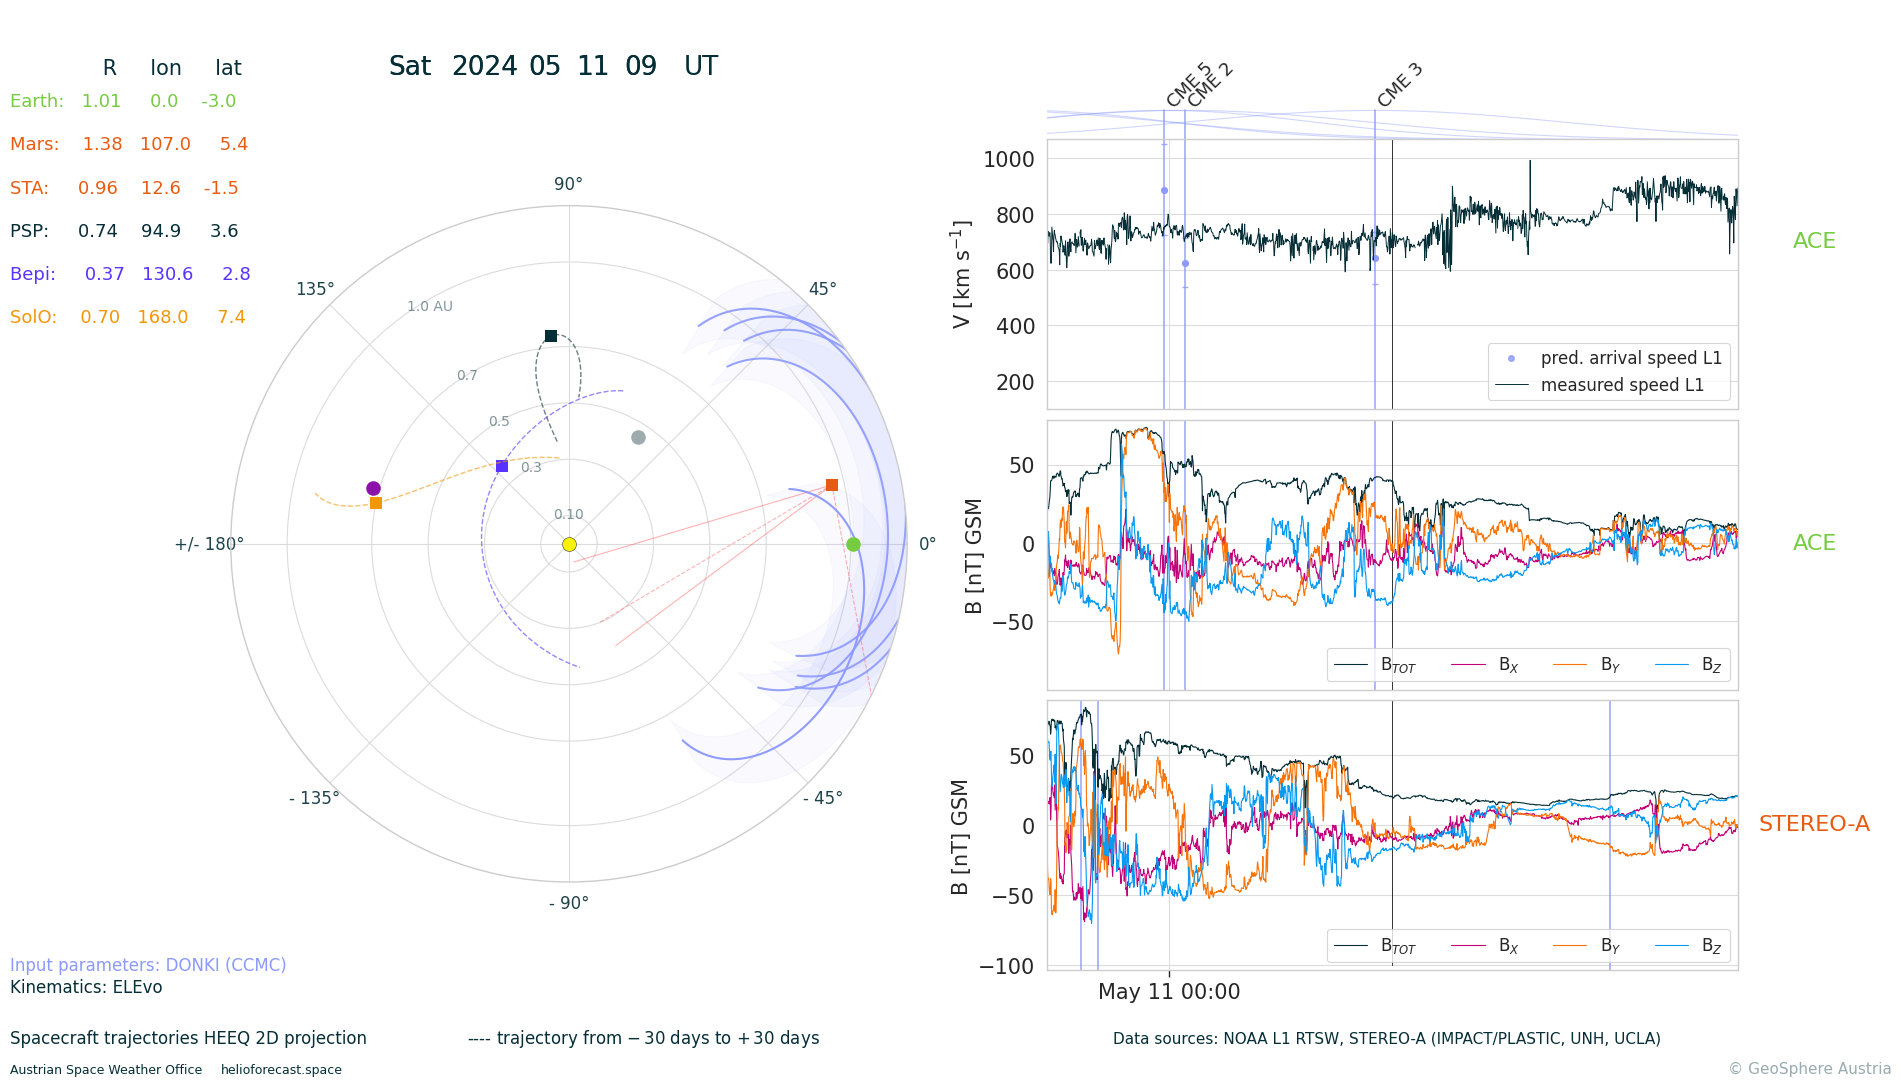

done


In [39]:
#for server
#matplotlib.use('Qt5Agg')

print('Save kinematics plots and overview plot for current time')

%matplotlib inline

start_time=time.time()

#print()
#print('make animation')

#animation start time in matplotlib format

frame_time_num=parse_time(t_start).plot_date

frame_time_num_list = [frame_time_num+k*res_in_days for k in range(k_all)]

k_today = np.where(frame_time_num_list==mdates.date2num(datetime.now().replace(microsecond=0, second=0, minute=0)))

#print(k_today)

sns.set_context('talk')
if not black: sns.set_style('whitegrid', {'xtick.bottom': True, 'grid.color': 'gainsboro'})
if black: sns.set_style('white',{'figure.facecolor':'white', 'grid.color': '#F4F4F4', 'axes.edgecolor': '#9AACAF', 'axes.facecolor': 'white'})   
#dae0e1
# animation settings 

sns.set_context('paper')

fsize=13
fadeind = 200*24 #if s/c positions are given in hourly resolution
#fadeind=int(20/res_in_days)##F4F4F4
#fadeind=int(120/res_in_days)

symsize_planet=110
symsize_spacecraft=80

#for parker spiral   
theta=np.arange(0,np.deg2rad(180),0.01)

####################### test animation frames (different frame numbers)
make_frame2(468)

print('done') 


## Make full movie

In [40]:

matplotlib.use('Agg')

print('Creating ', k_all,' frames')

print()

start_time=time.time()

#number of processes depends on your machines memory; check with command line "top"
#how much memory is used by all your processesii
nr_of_processes_used=75
print('Using multiprocessing, nr of cores',multiprocessing.cpu_count(), \
      'with nr of processes used: ',nr_of_processes_used)

#run multiprocessing pool to make all movie frames, depending only on frame number

pool=mp.get_context('fork').Pool(processes=nr_of_processes_used)


input=[i for i in np.arange(1,k_all,1)]
pool.map(make_frame, input)
pool.close()
pool.join()

print('time in min: ',np.round((time.time()-start_time)/60))
print('plots done, frames saved in ',outputdirectory)


Creating  559  frames

Using multiprocessing, nr of cores 128 with nr of processes used:  75
time in min:  1.0
plots done, frames saved in  elevo_frames/


In [41]:
date_today = datetime.now().strftime('%Y-%m-%d')

os.system(ffmpeg_path+'ffmpeg -r 20 -i '+str(outputdirectory)+'/pos_anim_%05d.jpg -b 5000k \
    -r 20 '+str(animdirectory)+'ELEvo_may_2024.mp4 -y -loglevel warning') 

print('movie done, saved in ',animdirectory)

Please use -b:a or -b:v, -b is ambiguous


movie done, saved in  elevo_movie/
